In [2]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import torch
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import yaml

from utils import add_attr_interface
from inference import encode_all
from metrics import compute_metrics, visualize_similarity_distrib

# Data loading

In [3]:
DATASET_ROOT_DIR = "../data/"
dataset_path = os.path.join(DATASET_ROOT_DIR, "dataset_big_patent_v1.json")

In [4]:
# Loading dataset
with open(dataset_path, "r") as json_file:
    dataset = json.load(json_file)

df = pd.DataFrame(dataset)
df.head()


,query,negative,pos
0,What are the key advantages and applications o...,The present technology introduces an innovativ...,RELATED APPLICATIONS This application claims t...
1,How does a magnetic energy harvester operate w...,The advanced energy accumulation equipment bei...,RELATED APPLICATIONS This application claims t...
2,How does an energy harvester operate without a...,The invention relates to the design and utilit...,RELATED APPLICATIONS This application claims t...
3,How can buffer blocks for ruminant animals be ...,The innovative technique pertains to mineral s...,BACKGROUND OF THE INVENTION I. Field of the In...
4,What advancements does the described patent pr...,The current text discusses a novel mechanical ...,RELATED APPLICATION The present application cl...


# Data analysis

## Dataset structure

In [25]:
print(f"Number of samples in dataset: {len(dataset)}")

Number of samples in dataset: 499


#### Study length distributions of entries

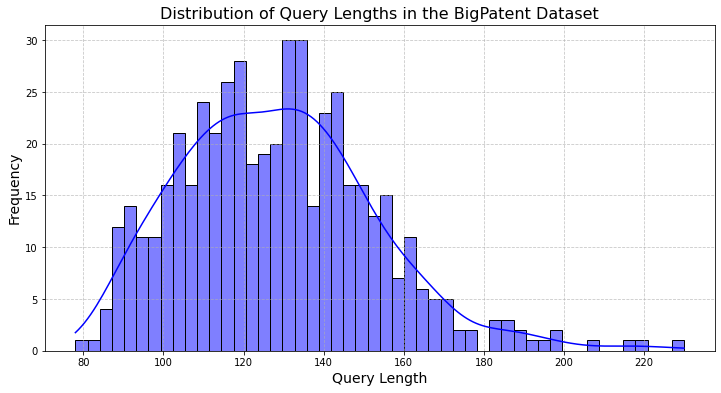

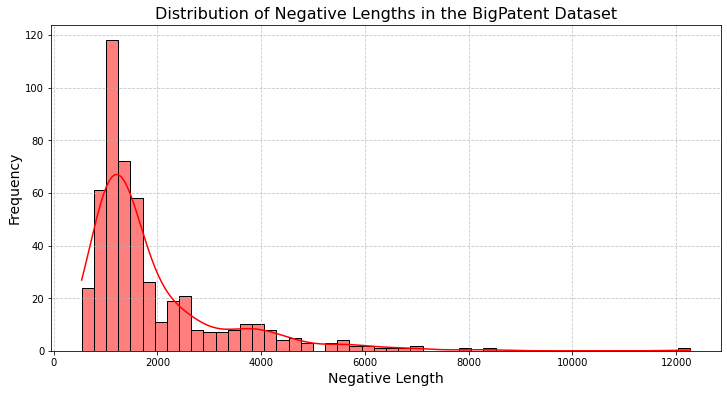

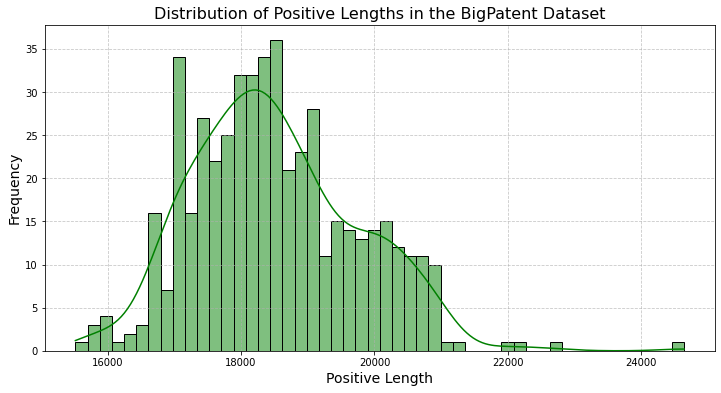

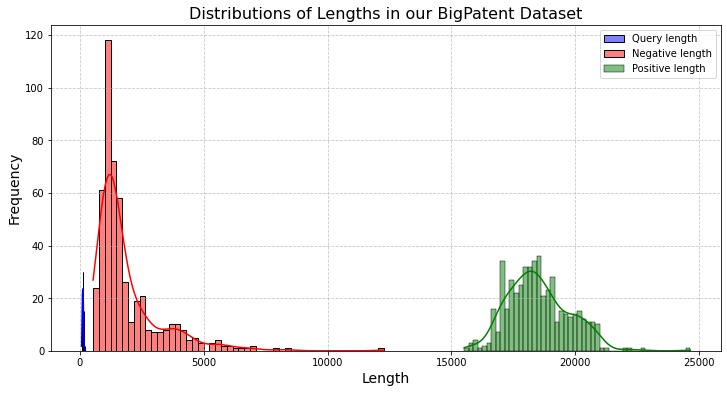

In [26]:
# Queries
plt.figure(figsize=(12, 6))
sns.histplot(df['query'].apply(len), bins=50, color='blue', label='Query length', kde=True)
plt.title('Distribution of Query Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Query Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Negatives
plt.figure(figsize=(12, 6))
sns.histplot(df['negative'].apply(len), bins=50, color='red', label='Negative length', kde=True)
plt.title('Distribution of Negative Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Negative Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Positives
plt.figure(figsize=(12, 6))
sns.histplot(df['pos'].apply(len), bins=50, color='green', label='Positive length', kde=True)
plt.title('Distribution of Positive Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Positive Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# All distribs at once
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(df['query'].apply(len), bins=50, color='blue', label='Query length', kde=True)
sns.histplot(df['negative'].apply(len), bins=50, color='red', label='Negative length', kde=True)
sns.histplot(df['pos'].apply(len), bins=50, color='green', label='Positive length', kde=True)
plt.title('Distributions of Lengths in our BigPatent Dataset', fontsize=16)
plt.xlabel('Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

#### Word Frequency

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words in queries: [('featur', 101), ('patent', 90), ('method', 86), ('improv', 84), ('innov', 75), ('describ', 73), ('devic', 69), ('use', 61), ('design', 57), ('system', 52), ('offer', 51), ('novel', 49), ('applic', 47), ('invent', 47), ('new', 46), ('advanc', 40), ('apparatu', 37), ('enhanc', 34), ('provid', 32), ('treatment', 29)]
Most common words in negatives: [('system', 767), ('devic', 680), ("'s", 648), ('design', 608), ('includ', 561), ('invent', 525), ('use', 508), ('mechan', 475), ('within', 399), ('structur', 389), ('compon', 366), ('specif', 357), ('enhanc', 344), ('process', 342), ('innov', 336), ('variou', 336), ('element', 323), ('applic', 321), ('oper', 320), ('method', 315)]
Most common words in positives: [('fig', 9122), ('invent', 7852), ('may', 6838), ('use', 6790), ('embodi', 4840), ('present', 4566), ('includ', 4460), ('provid', 4252), ('devic', 4246), ('one', 4186), ('show', 4077), ('1', 3987), ('2', 3578), ('first', 3520), ('prefer', 3425), ('end', 

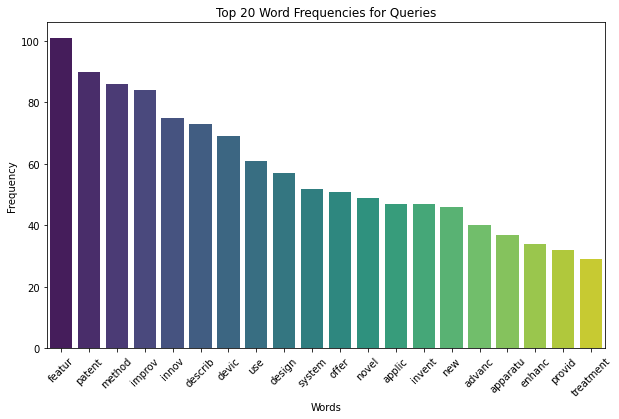

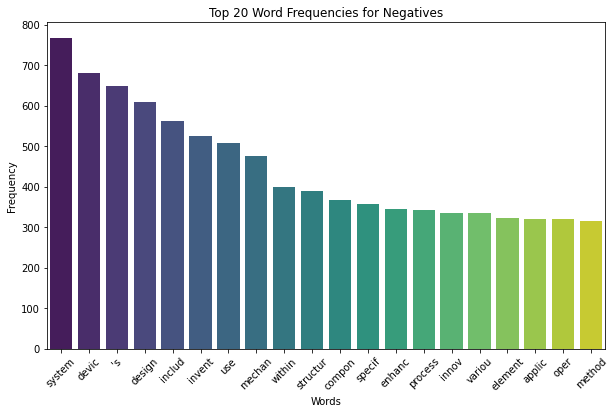

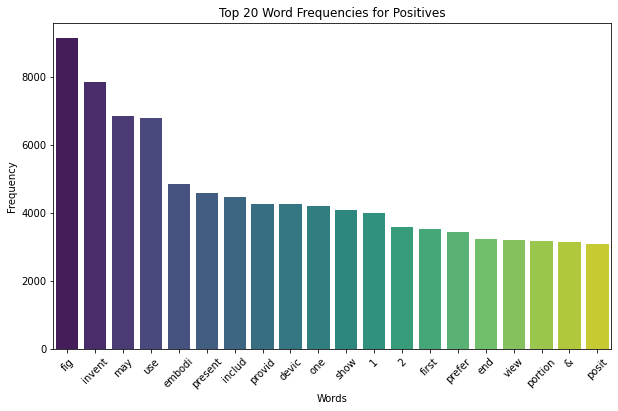

In [27]:
nltk.download('stopwords')
nltk.download('wordnet')
punctuations = ['.', ',', '?', '!', ';', '(', ')', '[', ']', '#', '/']
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words and word.lower() not in punctuations]
    return ' '.join(filtered_text)

def stem_words(text, stemmer):
    words = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_text)

def lemmatize_words(text, lemmatizer):
    words = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]
    return ' '.join(lemmatized_text)

def get_most_common_words(texts, num_words=20):
    all_words = [word.lower() for text in texts for word in word_tokenize(text)]
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Remove stop words, then apply stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for column in df:
    df[column] = df[column].apply(remove_stop_words)
    df[column] = df[column].apply(stem_words, args=[stemmer])
    df[column] = df[column].apply(lemmatize_words, args=[lemmatizer])


most_common_query = get_most_common_words(df['query'].tolist())
most_common_negative = get_most_common_words(df['negative'].tolist())
most_common_positive = get_most_common_words(df['pos'].tolist())
print("Most common words in queries:", most_common_query)
print("Most common words in negatives:", most_common_negative)
print("Most common words in positives:", most_common_positive)

# Separate words and their frequencies for plotting
words_query, counts_query = zip(*most_common_query)
words_negative, counts_negative = zip(*most_common_negative)
words_positive, counts_positive = zip(*most_common_positive)

# Create a DataFrame for Seaborn
df_query_freq = pd.DataFrame(most_common_query, columns=['Query_words', 'Frequency'])
df_negative_freq = pd.DataFrame(most_common_negative, columns=['Negative_words', 'Frequency'])
df_positive_freq = pd.DataFrame(most_common_positive, columns=['Positive_words', 'Frequency'])

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Query_words', y='Frequency', data=df_query_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Queries')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Negative_words', y='Frequency', data=df_negative_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Negatives')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Positive_words', y='Frequency', data=df_positive_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Positives')
plt.xticks(rotation=45)
plt.show()

#### TF-IDF

Top 20 words by TF-IDF score: [('invention', 0.10288066754333047), ('device', 0.08249829339415697), ('fig', 0.06436069475011388), ('apparatus', 0.0572446214381609), ('present', 0.05385258879168645), ('described', 0.04745069177981833), ('use', 0.04559532564970882), ('method', 0.04484615532716863), ('patient', 0.04379383320258505), ('treatment', 0.040976671938133306), ('mechanism', 0.040898023121388155), ('application', 0.03967729766972238), ('used', 0.03842928802638306), ('using', 0.0383832296215492), ('various', 0.037708294076508886), ('composition', 0.03622467535369711), ('non', 0.03531494278215465), ('body', 0.034005380110592974), ('includes', 0.03284382339765709), ('assembly', 0.03258332216154188)]


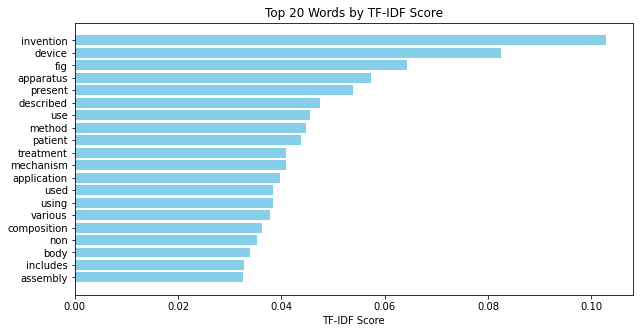

In [29]:
# Combine all texts for TF-IDF calculation
all_texts = df['query'].tolist() + df['negative'].tolist() + df['pos'].tolist()

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

# Get feature names (words) and their TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
tfidf_scores = list(zip(feature_names, tfidf_scores))
tfidf_scores.sort(key=lambda x: x[1], reverse=True)

# Display top 20 words by TF-IDF score
print("Top 20 words by TF-IDF score:", tfidf_scores[:20])

# Extract top 20 words by TF-IDF score for bar chart
top_words = tfidf_scores[:20]
words, scores = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.barh(words, scores, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.show()

# Zero-shot performances

In [36]:
cfg_path = "./config.yml"
split_path = "../data/indices_split.pkl"
model_name = "infgrad/stella-base-en-v2"  # sentence-transformers/all-mpnet-base-v2
batch_size = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load config
with open(cfg_path, 'r') as yml_file:
    cfg = add_attr_interface(yaml.safe_load(yml_file))
    
# Load test dataset (reload data to avoid word frequency analysis impact)
with open(split_path, 'rb') as pkl_file:
    test_indices = pickle.load(pkl_file)['test_indices']
with open(dataset_path, "r") as json_file:
    dataset = json.load(json_file)
df = pd.DataFrame(dataset)
df_test = df.iloc[test_indices]

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cfg.TRAIN.MODEL_CACHE_DIR)
model = AutoModel.from_pretrained(model_name, cache_dir=cfg.TRAIN.MODEL_CACHE_DIR)

In [37]:
query_embeddings, positive_embeddings, negative_embeddings = encode_all(tokenizer, model, df_test, batch_size, device)


[encode_all] - Processing query embeddings...
[get_embeddings] - processing batch n°1/4...
[get_embeddings] - processing batch n°2/4...
[get_embeddings] - processing batch n°3/4...
[get_embeddings] - processing batch n°4/4...

[encode_all] - Processing positives embeddings...
[get_embeddings] - processing batch n°1/4...
[get_embeddings] - processing batch n°2/4...
[get_embeddings] - processing batch n°3/4...
[get_embeddings] - processing batch n°4/4...

[encode_all] - Processing negatives embeddings...
[get_embeddings] - processing batch n°1/4...
[get_embeddings] - processing batch n°2/4...
[get_embeddings] - processing batch n°3/4...
[get_embeddings] - processing batch n°4/4...


In [39]:
metrics = compute_metrics(query_embeddings, positive_embeddings, negative_embeddings)
print("metrics = \n", metrics)

MRR Score: 0.6866666666666665
Accuracy: 0.56
metrics = 
 {'pos_similarities': array([0.7399048 , 0.8394201 , 0.81760067, 0.7597331 , 0.8210263 ,
       0.80331767, 0.75082874, 0.78870773, 0.72243774, 0.75695544,
       0.780735  , 0.780426  , 0.77578413, 0.78949076, 0.76687163,
       0.8226297 , 0.8652059 , 0.82787883, 0.7258701 , 0.8515191 ,
       0.82095134, 0.83887386, 0.77668506, 0.7419816 , 0.83402365,
       0.8542605 , 0.79897034, 0.86163414, 0.87151647, 0.796453  ,
       0.8525507 , 0.8023601 , 0.8190063 , 0.81341857, 0.8223986 ,
       0.82898986, 0.85720134, 0.8518169 , 0.83468586, 0.80456626,
       0.79189825, 0.7834506 , 0.79158354, 0.8130396 , 0.7664051 ,
       0.7388449 , 0.82189465, 0.80937004, 0.82792985, 0.77659875],
      dtype=float32), 'neg_similarities': array([0.772019  , 0.8008791 , 0.80897707, 0.7790779 , 0.85534346,
       0.8214388 , 0.70879525, 0.74657476, 0.7547024 , 0.75938696,
       0.8364499 , 0.7982121 , 0.8004686 , 0.8605541 , 0.83510613,
       0

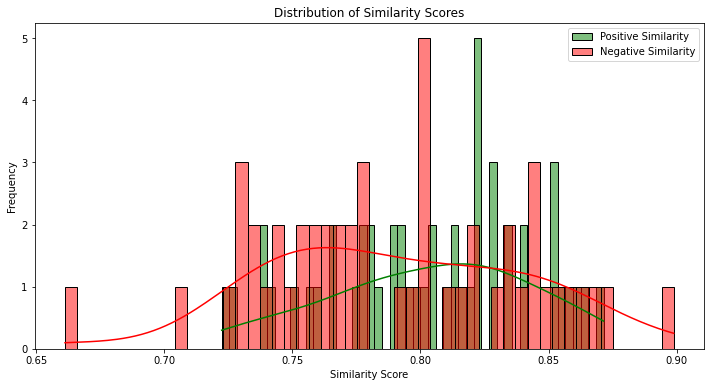

In [40]:
visualize_similarity_distrib(metrics)

# Fined-tuned model performances

In [6]:
data_path = "../data/dataset_big_patent_v1.json"
cfg_path = "./config.yml"  
split_path = "../data/indices_split.pkl"
model_path = "../outputs/2024_06_13-15h13_stella-base-en-v2/models"  
model_name = "infgrad/stella-base-en-v2"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load config file
with open(cfg_path) as yml_file:
    cfg = add_attr_interface(yaml.safe_load(yml_file))

# Load test dataset
with open(split_path, 'rb') as pkl_file:
    test_indices = pickle.load(pkl_file)['test_indices']

with open(data_path, 'r') as json_file:
    dataset = json.load(json_file)
df = pd.DataFrame(dataset)
test_df = df.iloc[test_indices]

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cfg.TRAIN.MODEL_CACHE_DIR)
model = AutoModel.from_pretrained(model_path).to(device)

In [42]:
query_embeddings, positive_embeddings, negative_embeddings = encode_all(tokenizer, model, test_df, batch_size=8)


[encode_all] - Processing query embeddings...
[get_embeddings] - processing batch n°1/7...
[get_embeddings] - processing batch n°2/7...
[get_embeddings] - processing batch n°3/7...
[get_embeddings] - processing batch n°4/7...
[get_embeddings] - processing batch n°5/7...
[get_embeddings] - processing batch n°6/7...
[get_embeddings] - processing batch n°7/7...

[encode_all] - Processing positives embeddings...
[get_embeddings] - processing batch n°1/7...
[get_embeddings] - processing batch n°2/7...
[get_embeddings] - processing batch n°3/7...
[get_embeddings] - processing batch n°4/7...
[get_embeddings] - processing batch n°5/7...
[get_embeddings] - processing batch n°6/7...
[get_embeddings] - processing batch n°7/7...

[encode_all] - Processing negatives embeddings...
[get_embeddings] - processing batch n°1/7...
[get_embeddings] - processing batch n°2/7...
[get_embeddings] - processing batch n°3/7...
[get_embeddings] - processing batch n°4/7...
[get_embeddings] - processing batch n°5/7

In [43]:
metrics = compute_metrics(query_embeddings, positive_embeddings, negative_embeddings)
metrics

MRR Score: 1.0
Accuracy: 1.0


{'pos_similarities': array([0.7290403 , 0.840643  , 0.7767341 , 0.7205058 , 0.7534384 ,
        0.75181264, 0.7174039 , 0.75946635, 0.7052156 , 0.77662075,
        0.7709286 , 0.7442471 , 0.7985686 , 0.75757766, 0.7364011 ,
        0.8419082 , 0.8506593 , 0.80163026, 0.7335551 , 0.7984549 ,
        0.8292946 , 0.8170378 , 0.73069674, 0.81313765, 0.8066001 ,
        0.7816735 , 0.75842726, 0.78650737, 0.7844776 , 0.7976441 ,
        0.76862174, 0.7400348 , 0.7359719 , 0.80621547, 0.7558871 ,
        0.76262486, 0.84940994, 0.828619  , 0.8184644 , 0.7944907 ,
        0.81004167, 0.80633837, 0.693328  , 0.730719  , 0.7062886 ,
        0.7320931 , 0.7881362 , 0.7445152 , 0.84228516, 0.6656383 ],
       dtype=float32),
 'neg_similarities': array([0.6268791 , 0.5851425 , 0.6786851 , 0.5647615 , 0.6556997 ,
        0.6840098 , 0.52468723, 0.67829907, 0.5671527 , 0.53883517,
        0.5878114 , 0.5910976 , 0.5749259 , 0.5170847 , 0.52089095,
        0.63935137, 0.7185428 , 0.45179528, 0.631964

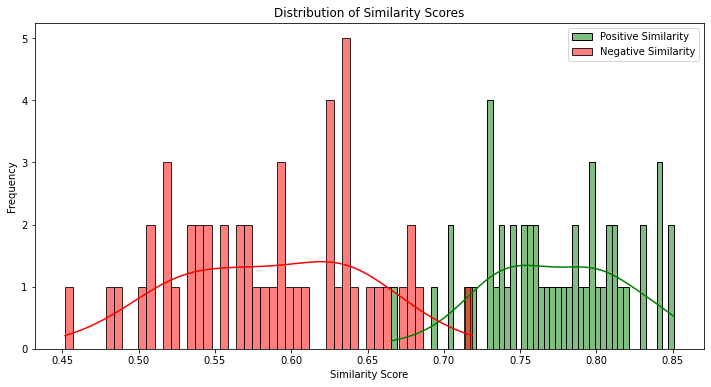

In [44]:
visualize_similarity_distrib(metrics)

### Model attack on input length

In [48]:
queries = test_df['query'].tolist()
negatives, positives = [], []
for _, _, neg, pos in test_df.itertuples():
    negatives.append("bla" * (len(neg) // 3))  # Get a similar length answer
    positives.append("bla" * (len(pos) // 3))  # Get a similar length answer

query_tokens = tokenizer(queries, padding=True, truncation=True, return_tensors="pt").to(device)
negative_tokens = tokenizer(negatives, padding=True, truncation=True, return_tensors="pt").to(device)
positive_tokens = tokenizer(positives, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    query_emb = model(**query_tokens).last_hidden_state.mean(dim=1)
    negative_emb = model(**negative_tokens).last_hidden_state.mean(dim=1)
    positive_emb = model(**positive_tokens).last_hidden_state.mean(dim=1)
    
query_pos_sim = cosine_similarity(query_emb, positive_emb).diagonal().mean()
query_neg_sim = cosine_similarity(query_emb, negative_emb).diagonal().mean()
print("query_pos_sim = ", query_pos_sim)
print("query_neg_sim = ", query_neg_sim)

query_pos_sim =  0.50751895
query_neg_sim =  0.50751895


### Model attack on semantics

Replace important words of positive samples by typical important words in other texts, and study impact on query-positive similarity.

In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sample_idx = 0
positive_length_peak = 18000  # Read from length analysis

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
positives = test_df['pos']
tfidf_matrix = tfidf_vectorizer.fit_transform(positives)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute TF-IDF scores for words in texts
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix_all_texts = vectorizer.fit_transform(test_df['query'].tolist() + test_df['pos'].tolist() + test_df['negative'].tolist())
feature_names_all_texts = vectorizer.get_feature_names_out()
 
# Compute TF-IDF scores for words in positives
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix_positives = vectorizer.fit_transform(test_df['pos'].tolist())
feature_names_positives = vectorizer.get_feature_names_out()

query_pos_sim = 0
for i, sentence in enumerate(test_df['pos']):
    print(f"Processing sentence n°{i}...")
    # Step 2: Identify the most important word(s) in each sentence
    tfidf_scores = tfidf_matrix_positives[i].toarray().flatten()
    word_idx = np.argmax(tfidf_scores)
    word = feature_names[word_idx]
    
    # Step 3: Replace the most important word with another word
    replacement_word = feature_names_all_texts[random.randint(0, len(feature_names_all_texts)-1)]
    altered_sentence = sentence.replace(word, replacement_word)
    
    # Print original and altered sentences
    print(f"Changed '{word}' by '{replacement_word}' in '{sentence}'.")

    query_tokens = tokenizer(query, padding=True, truncation=True, return_tensors="pt").to(device)
    positive_tokens = tokenizer(altered_sentence, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        query_emb = model(**query_tokens).last_hidden_state.mean(dim=1)
        positive_emb = model(**positive_tokens).last_hidden_state.mean(dim=1)
        
    sim = cosine_similarity(query_emb, positive_emb)[0][0]
    print('sim = ', sim)
    query_pos_sim += sim
    
print("mean query_pos_sim for altered sentences = ", query_pos_sim / len(test_df['pos']))

Processing sentence n°0...
Changed 'effect' by 'valve' in '[0001] This application is a national stage filing under 35 U.S.C. 371 of PCT application PCT/SE01/01162, filed May 22, 2001, which claims priority from United Kingdom Application No. 0012291.1, filed May 23, 2000, the specifications of each of which are incorporated by reference herein. PCT Application PCT/SE01/01162 was published under PCT Article 21(2) in English. [0002] The present invention relates to a pharmaceutical product, daily dose or dose regimen comprising 4′-cyano-β′,α′,α′-trifluoro-3-(4-fluorophenylsulphonyl)-2-hydroxy-2-methylpropiono-m-toluidide and tamoxifen. The invention also relates to a method of providing an anti-androgenic effect and an anti-oestrogenic effect in a patient, wherein the anti-oestrogenic effect is provided substantially without causing an additional increase in the levels of circulating androgens. Furthermore, the invention relates to the use of 4′-cyano-β′,α′,α′-trifluoro-3-(4-fluoropheny